# Deep learning for computer vision


This notebook will teach you to build and train convolutional networks for image recognition. Brace yourselves.

# CIFAR dataset
This week, we shall focus on the image recognition problem on cifar10 dataset
* 60k images of shape 3x32x32
* 10 different classes: planes, dogs, cats, trucks, etc.

<img src="https://github.com/yandexdataschool/Practical_DL/blob/fall19/week03_convnets/cifar10.jpg?raw=1" style="width:80%">

In [1]:
# when running in colab, un-comment this# 
!wget https://raw.githubusercontent.com/yandexdataschool/Practical_DL/fall19/week03_convnets/cifar.py

--2019-10-06 13:14:39--  https://raw.githubusercontent.com/yandexdataschool/Practical_DL/fall19/week03_convnets/cifar.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2396 (2.3K) [text/plain]
Saving to: ‘cifar.py’

cifar.py            100%[===================>]   2.34K  --.-KB/s    in 0s      

2019-10-06 13:14:40 (78.2 MB/s) - ‘cifar.py’ saved [2396/2396]



In [2]:
import numpy as np
from cifar import load_cifar10
X_train, y_train, X_val, y_val, X_test, y_test = load_cifar10("cifar_data")

class_names = np.array(['airplane', 'automobile', 'bird', 'cat', 'deer',
                        'dog', 'frog', 'horse', 'ship', 'truck'])

print(X_train.shape,y_train.shape)

Dataset not found. Downloading...
(40000, 3, 32, 32) (40000,)


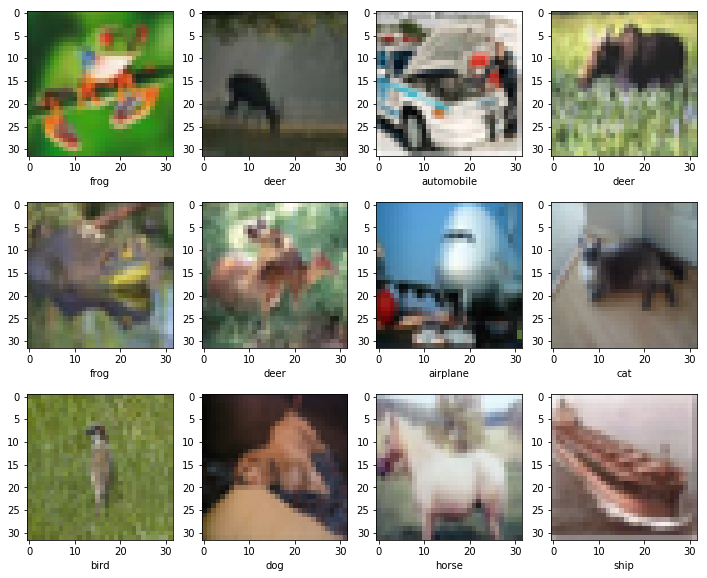

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=[12,10])
for i in range(12):
    plt.subplot(3,4,i+1)
    plt.xlabel(class_names[y_train[i]])
    plt.imshow(np.transpose(X_train[i],[1,2,0]))

# Building a network

Simple neural networks with layers applied on top of one another can be implemented as `torch.nn.Sequential` - just add a list of pre-built modules and let it train.

In [0]:
import torch, torch.nn as nn
import torch.nn.functional as F

# a special module that converts [batch, channel, w, h] to [batch, units]
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

Let's start with a dense network for our baseline:

I started with base neural network, which was described below. After some experiments I started to create my own neural network.
First I added conv layer, batch normalization for it and activation function (relu). After that I took a two final layers from baseline network and for these layers added flatten layer and dense after it (relu too). After every group of layer or new layer I calculate accuracy and wrote it after layer. 
When experiments with current layers couldn't upgrade result significantly, I tried to add new conv layer. Some parts of these experiments remained as comment lines. Linear layer's size for example.

1) I added first conv layer with kernel_size=6, because it can be a length of some object on image (horse's leg for example). It gave not so bad results for 2 conv layers, but after third conv layer kernel_size was changed to 4 and after fourth it became equal to 3. 

I added batch_norm layer, because it stabilized optimizers steps. And after adding pooling1 layer accuracy increased from 59% to 65%. At next blocks I tried to do the same things.

2) After that I added second conv layer and accuracy increased significantly to ~67%. Added batch_norm layer just because I can and because it gave 1% more accuracy. Some experiments with kernel size and out channels didn't change results as much as I wanted. Adding pooling layer decreased accuracy (don't understand why, but it was). Kernel size was 4, when second conv layer was created, but then I changed it to 2, because it increase accuracy.

3) After adding 3 layer accuracy increased to 70% and I tried to add batchnorm, activation function. It gave 70% accuracy. Adding pooling2 layer increases accuracy to 73%. I don't understand why it worked here, but not on a previous step.

4) Fourt conv layer, batach_norm for it and activation layers gave 74,97% accuracy. Very very close, but still not 75%. After adding pooling layer accuracy became less, than before. It was third time, when I didn't understand when pooling must help. I added one more activation and linear layer before final block, and it didn't increase accuracy. I tried to change layers from previous blocks, for example add stride to conv layers, but it was useless.
At the end I moved pooling layers, which was after first and third blocks to positions after second and fourth blocks. And it increase accuracy to 76%.

Common notes: Sigmoid, SoftMax, Tanh worse than elu, relu, and other \*lu. Increasing out_channels at conv layers increase accuracy a little bit, so these parameters were changed several times, when I was thinking, that it can help.

In [617]:
model = nn.Sequential()

model.add_module('conv1', nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3)) # start with 6 kernel size
model.add_module('batch1', nn.BatchNorm2d(16))
model.add_module('relu1', nn.ReLU())
#model.add_module('flat1', nn.Flatten())
#model.add_module('dense1', nn.Linear(11664, 2400))
# 59.97 %
#pooling1 was here

#model.add_module('flat2', nn.Flatten())
#model.add_module('dense2', nn.Linear(2704, 2400))
# 65.40 %

model.add_module('conv2', nn.Conv2d(in_channels=16, out_channels=32, kernel_size=2)) # start with 4 kernel size
# 67.94 % for conv2, flat3, dense3
model.add_module('batch2', nn.BatchNorm2d(32))
model.add_module('elu1', nn.ELU())

model.add_module('pooling1', nn.MaxPool2d(2))
# model.add_module('flat3', nn.Flatten())
# model.add_module('dense3', nn.Linear(3200, 1200))
# 68.83 %

model.add_module('conv3', nn.Conv2d(in_channels=32, out_channels=64, kernel_size=2))
model.add_module('batchnorm3', nn.BatchNorm2d(64))
model.add_module('celu', nn.CELU())
# 70.16 % conv3, batchnorm3, celu, flat4, dense4

#pooling 2 was here
#add pooling2 73.83 %

# model.add_module('flat4', nn.Flatten())
# model.add_module('dense4', nn.Linear(2304, 1200))

model.add_module('conv4', nn.Conv2d(in_channels=64, out_channels=128, kernel_size=2))
model.add_module('relu2', nn.ReLU())

model.add_module('pooling2', nn.AvgPool2d(2, stride=2))

model.add_module('flat5', nn.Flatten())
model.add_module('dense5', nn.Linear(4608, 1024))
                 
# 74.97 % conv4, relu2, flat5, dense5
model.add_module('relu3', nn.ReLU())
model.add_module('dense*', nn.Linear(1024, 128))
# last layers

# final block
model.add_module('relu4', nn.ReLU())
model.add_module('dense6', nn.Linear(128, 10))

model.cuda()

Sequential(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
  (batch1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (conv2): Conv2d(16, 32, kernel_size=(2, 2), stride=(1, 1))
  (batch2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (elu1): ELU(alpha=1.0)
  (pooling1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 64, kernel_size=(2, 2), stride=(1, 1))
  (batchnorm3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (celu): CELU(alpha=1.0)
  (conv4): Conv2d(64, 128, kernel_size=(2, 2), stride=(1, 1))
  (relu2): ReLU()
  (pooling2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (flat5): Flatten()
  (dense5): Linear(in_features=4608, out_features=1024, bias=True)
  (sigm): ReLU()
  (dense*): Linear(in_features=1024, out_features=128, bias=True)
  (relu3): ReLU()
  (dense6): Linear(in_features=128, out

As in our basic tutorial, we train our model with negative log-likelihood aka crossentropy.

In [0]:
def compute_loss(X_batch, y_batch):
    X_batch = torch.as_tensor(X_batch, dtype=torch.float32).cuda()
    y_batch = torch.as_tensor(y_batch, dtype=torch.int64).cuda()
    logits = model(X_batch)
    return F.cross_entropy(logits, y_batch).mean()

In [619]:
# example
compute_loss(X_train[:50], y_train[:50])

tensor(2.3075, device='cuda:0', grad_fn=<MeanBackward0>)

### Training on minibatches
* We got 40k images, that's way too many for a full-batch SGD. Let's train on minibatches instead
* Below is a function that splits the training sample into minibatches

In [0]:
# An auxilary function that returns mini-batches for neural network training
def iterate_minibatches(X, y, batchsize):
    indices = np.random.permutation(np.arange(len(X)))
    for start in range(0, len(indices), batchsize):
        ix = indices[start: start + batchsize]
        yield X[ix], y[ix]

In [621]:
opt = torch.optim.Adam(model.parameters(), lr=0.0007)

train_loss = []
val_accuracy = []

import time
num_epochs = 100 # total amount of full passes over training data
batch_size = 800  # number of samples processed in one SGD iteration

for epoch in range(num_epochs):
    # In each epoch, we do a full pass over the training data:
    start_time = time.time()
    model.train(True) # enable dropout / batch_norm training behavior
    for X_batch, y_batch in iterate_minibatches(X_train, y_train, batch_size):
        # train on batch
        loss = compute_loss(X_batch, y_batch)
        loss.backward()
        opt.step()
        opt.zero_grad()
        train_loss.append(loss.data.cpu().numpy())
        
    # And a full pass over the validation data:
    model.train(False) # disable dropout / use averages for batch_norm
    for X_batch, y_batch in iterate_minibatches(X_val, y_val, batch_size):
        logits = model(torch.as_tensor(X_batch, dtype=torch.float32).cuda())
        y_pred = logits.max(1)[1].data.cpu().numpy()
        val_accuracy.append(np.mean(y_batch == y_pred))

    
    # Then we print the results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))
    print("  training loss (in-iteration): \t{:.6f}".format(
        np.mean(train_loss[-len(X_train) // batch_size :])))
    print("  validation accuracy: \t\t\t{:.2f} %".format(
        np.mean(val_accuracy[-len(X_val) // batch_size :]) * 100))

Epoch 1 of 100 took 6.411s
  training loss (in-iteration): 	1.567744
  validation accuracy: 			48.06 %
Epoch 2 of 100 took 6.353s
  training loss (in-iteration): 	1.175817
  validation accuracy: 			58.74 %
Epoch 3 of 100 took 6.331s
  training loss (in-iteration): 	0.981954
  validation accuracy: 			64.75 %
Epoch 4 of 100 took 6.302s
  training loss (in-iteration): 	0.855774
  validation accuracy: 			67.13 %
Epoch 5 of 100 took 6.311s
  training loss (in-iteration): 	0.739021
  validation accuracy: 			72.24 %
Epoch 6 of 100 took 6.302s
  training loss (in-iteration): 	0.632828
  validation accuracy: 			72.59 %
Epoch 7 of 100 took 6.319s
  training loss (in-iteration): 	0.549527
  validation accuracy: 			73.61 %
Epoch 8 of 100 took 6.303s
  training loss (in-iteration): 	0.455502
  validation accuracy: 			73.44 %
Epoch 9 of 100 took 6.328s
  training loss (in-iteration): 	0.379335
  validation accuracy: 			74.39 %
Epoch 10 of 100 took 6.300s
  training loss (in-iteration): 	0.288936
  v

Don't wait for full 100 epochs. You can interrupt training after 5-20 epochs once validation accuracy stops going up.
```

```

```

```

```

```

```

```

```

```

### Final test

In [622]:
model.train(False) # disable dropout / use averages for batch_norm
test_batch_acc = []
for X_batch, y_batch in iterate_minibatches(X_test, y_test, 500):
    logits = model(torch.as_tensor(X_batch, dtype=torch.float32).cuda())
    y_pred = logits.max(1)[1].data.cpu().numpy()
    test_batch_acc.append(np.mean(y_batch == y_pred))

test_accuracy = np.mean(test_batch_acc)
    
print("Final results:")
print("  test accuracy:\t\t{:.2f} %".format(
    test_accuracy * 100))

if test_accuracy * 100 > 95:
    print("Double-check, than consider applying for NIPS'17. SRSly.")
elif test_accuracy * 100 > 90:
    print("U'r freakin' amazin'!")
elif test_accuracy * 100 > 80:
    print("Achievement unlocked: 110lvl Warlock!")
elif test_accuracy * 100 > 70:
    print("Achievement unlocked: 80lvl Warlock!")
elif test_accuracy * 100 > 60:
    print("Achievement unlocked: 70lvl Warlock!")
elif test_accuracy * 100 > 50:
    print("Achievement unlocked: 60lvl Warlock!")
else:
    print("We need more magic! Follow instructons below")

Final results:
  test accuracy:		76.01 %
Achievement unlocked: 80lvl Warlock!


## Task I: small convolution net
### First step

Let's create a mini-convolutional network with roughly such architecture:
* Input layer
* 3x3 convolution with 10 filters and _ReLU_ activation
* 2x2 pooling (or set previous convolution stride to 3)
* Flatten
* Dense layer with 100 neurons and _ReLU_ activation
* 10% dropout
* Output dense layer.


__Convolutional layers__ in torch are just like all other layers, but with a specific set of parameters:

__`...`__

__`model.add_module('conv1', nn.Conv2d(in_channels=3, out_channels=10, kernel_size=3)) # convolution`__

__`model.add_module('pool1', nn.MaxPool2d(2)) # max pooling 2x2`__

__`...`__


Once you're done (and compute_loss no longer raises errors), train it with __Adam__ optimizer with default params (feel free to modify the code above).

If everything is right, you should get at least __50%__ validation accuracy.

```

```

```

```

```

```

```

```

```

```

__Hint:__ If you don't want to compute shapes by hand, just plug in any shape (e.g. 1 unit) and run compute_loss. You will see something like this:

__`RuntimeError: size mismatch, m1: [5 x 1960], m2: [1 x 64] at /some/long/path/to/torch/operation`__

See the __1960__ there? That's your actual input shape.

## Task 2: adding normalization

* Add batch norm (with default params) between convolution and ReLU
  * nn.BatchNorm*d (1d for dense, 2d for conv)
  * usually better to put them after linear/conv but before nonlinearity
* Re-train the network with the same optimizer, it should get at least 60% validation accuracy at peak.




```

```

```

```

```

```

```

```

```

```

```

```

```

```
## Task 3: Data Augmentation

There's a powerful torch tool for image preprocessing useful to do data preprocessing and augmentation.

Here's how it works: we define a pipeline that
* makes random crops of data (augmentation)
* randomly flips image horizontally (augmentation)
* then normalizes it (preprocessing)

In [0]:
from torchvision import transforms
means = np.array((0.4914, 0.4822, 0.4465))
stds = np.array((0.2023, 0.1994, 0.2010))

transform_augment = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomRotation([-30, 30]),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(means, stds),
])

In [0]:
from torchvision.datasets import CIFAR10
train_loader = CIFAR10("./cifar_data/", train=True, transform=transform_augment)

train_batch_gen = torch.utils.data.DataLoader(train_loader, 
                                              batch_size=32,
                                              shuffle=True,
                                              num_workers=1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


X: <class 'torch.Tensor'> torch.Size([32, 3, 32, 32])
y: <class 'torch.Tensor'> torch.Size([32])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


NotImplementedError: ignored

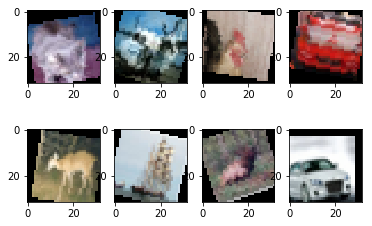

In [673]:

for (x_batch, y_batch) in train_batch_gen:
    
    print('X:', type(x_batch), x_batch.shape)
    print('y:', type(y_batch), y_batch.shape)
    
    for i, img in enumerate(x_batch.numpy()[:8]):
        plt.subplot(2, 4, i+1)
        plt.imshow(img.transpose([1,2,0]) * stds + means )
        
    
    raise NotImplementedError("Plese use this code in your training loop")
    # TODO use this in your training loop

When testing, we don't need random crops, just normalize with same statistics.

In [0]:
model = nn.Sequential()

model.add_module('conv1', nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3)) # start with 6 kernel size
model.add_module('batch1', nn.BatchNorm2d(16))
model.add_module('relu1', nn.ReLU())

model.add_module('conv2', nn.Conv2d(in_channels=16, out_channels=32, kernel_size=2)) # start with 4 kernel size
model.add_module('batch2', nn.BatchNorm2d(32))
model.add_module('elu1', nn.ELU())
model.add_module('pooling1', nn.MaxPool2d(2))

model.add_module('conv3', nn.Conv2d(in_channels=32, out_channels=64, kernel_size=2))
model.add_module('batchnorm3', nn.BatchNorm2d(64))
model.add_module('celu', nn.CELU())

model.add_module('conv4', nn.Conv2d(in_channels=64, out_channels=128, kernel_size=2))
model.add_module('relu2', nn.ReLU())
model.add_module('pooling2', nn.AvgPool2d(2, stride=2))

model.add_module('flat5', nn.Flatten())
model.add_module('dense5', nn.Linear(4608, 1024))                 
model.add_module('relu3', nn.ReLU())
model.add_module('dense*', nn.Linear(1024, 128))

model.add_module('relu4', nn.ReLU())
model.add_module('dense6', nn.Linear(128, 10))

model.cuda()

def compute_loss(X_batch, y_batch):
    X_batch = torch.as_tensor(X_batch, dtype=torch.float32).cuda()
    y_batch = torch.as_tensor(y_batch, dtype=torch.int64).cuda()
    logits = model(X_batch)
    return F.cross_entropy(logits, y_batch).mean()

In [10]:
opt = torch.optim.Adam(model.parameters(), lr=0.0007)

train_loss = []
val_accuracy = []

import time
num_epochs = 100 # total amount of full passes over training data
batch_size = 32  # number of samples processed in one SGD iteration

for epoch in range(num_epochs):
    # In each epoch, we do a full pass over the training data:
    start_time = time.time()
    model.train(True) # enable dropout / batch_norm training behavior
    for (x_batch, y_batch) in train_batch_gen:
    #for X_batch, y_batch in iterate_minibatches(X_train, y_train, batch_size):
        # train on batch
        loss = compute_loss(x_batch, y_batch)
        loss.backward()
        opt.step()
        opt.zero_grad()
        train_loss.append(loss.data.cpu().numpy())
        
    # And a full pass over the validation data:
    model.train(False) # disable dropout / use averages for batch_norm
    for (x_batch, y_batch) in train_batch_gen:
    #for X_batch, y_batch in iterate_minibatches(X_val, y_val, batch_size):
        logits = model(torch.as_tensor(x_batch, dtype=torch.float32).cuda())
        y_pred = logits.max(1)[1].data.cpu().numpy()
        val_accuracy.append(np.mean(y_batch.numpy() == y_pred))

    
    # Then we print the results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))
#     print("  training loss (in-iteration): \t{:.6f}".format(
#         np.mean(train_loss[-len(X_train) // batch_size :])))
#     print("  validation accuracy: \t\t\t{:.2f} %".format(
#         np.mean(val_accuracy[-len(X_val) // batch_size :]) * 100))

Epoch 1 of 100 took 54.411s
Epoch 2 of 100 took 55.074s
Epoch 3 of 100 took 55.265s
Epoch 4 of 100 took 55.091s
Epoch 5 of 100 took 56.903s
Epoch 6 of 100 took 55.960s
Epoch 7 of 100 took 55.994s
Epoch 8 of 100 took 55.847s
Epoch 9 of 100 took 55.431s
Epoch 10 of 100 took 56.003s
Epoch 11 of 100 took 55.592s
Epoch 12 of 100 took 56.315s
Epoch 13 of 100 took 56.240s
Epoch 14 of 100 took 56.217s
Epoch 15 of 100 took 56.157s
Epoch 16 of 100 took 56.540s
Epoch 17 of 100 took 56.085s
Epoch 18 of 100 took 56.364s
Epoch 19 of 100 took 56.547s
Epoch 20 of 100 took 55.749s
Epoch 21 of 100 took 56.065s
Epoch 22 of 100 took 54.866s
Epoch 23 of 100 took 55.020s
Epoch 24 of 100 took 54.509s
Epoch 25 of 100 took 53.770s
Epoch 26 of 100 took 53.195s
Epoch 27 of 100 took 54.071s
Epoch 28 of 100 took 54.449s
Epoch 29 of 100 took 54.097s
Epoch 30 of 100 took 53.778s
Epoch 31 of 100 took 54.151s
Epoch 32 of 100 took 53.956s
Epoch 33 of 100 took 54.259s
Epoch 34 of 100 took 54.013s
Epoch 35 of 100 took 53

In [0]:
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(means, stds),
])

test_loader = CIFAR10("./cifar_data/", train=False, transform=transform_test)

test_batch_gen = torch.utils.data.DataLoader(test_loader, 
                                              batch_size=500,
                                              shuffle=True,
                                              num_workers=1)#<YOUR CODE>

In [12]:
model.train(False) # disable dropout / use averages for batch_norm
test_batch_acc = []
for X_batch, y_batch in test_batch_gen:
    logits = model(torch.as_tensor(X_batch, dtype=torch.float32).cuda())
    y_pred = logits.max(1)[1].data.cpu().numpy()
    test_batch_acc.append(np.mean(y_batch.numpy() == y_pred))

test_accuracy = np.mean(test_batch_acc)
    
print("Final results:")
print("  test accuracy:\t\t{:.2f} %".format(test_accuracy * 100))

Final results:
  test accuracy:		84.90 %


# Homework 2.2: The Quest For A Better Network

In this assignment you will build a monster network to solve CIFAR10 image classification.

This notebook is intended as a sequel to seminar 3, please give it a try if you haven't done so yet.

(please read it at least diagonally)

* The ultimate quest is to create a network that has as high __accuracy__ as you can push it.
* There is a __mini-report__ at the end that you will have to fill in. We recommend reading it first and filling it while you iterate.
 
## Grading
* starting at zero points
* +20% for describing your iteration path in a report below.
* +20% for building a network that gets above 20% accuracy
* +10% for beating each of these milestones on __TEST__ dataset:
    * 50% (50% points)
    * 60% (60% points)
    * 65% (70% points)
    * 70% (80% points)
    * 75% (90% points)
    * 80% (full points)
    
## Restrictions
* Please do NOT use pre-trained networks for this assignment until you reach 80%.
 * In other words, base milestones must be beaten without pre-trained nets (and such net must be present in the e-mail). After that, you can use whatever you want.
* you __can__ use validation data for training, but you __can't'__ do anything with test data apart from running the evaluation procedure.

## Tips on what can be done:


 * __Network size__
   * MOAR neurons, 
   * MOAR layers, ([torch.nn docs](http://pytorch.org/docs/master/nn.html))

   * Nonlinearities in the hidden layers
     * tanh, relu, leaky relu, etc
   * Larger networks may take more epochs to train, so don't discard your net just because it could didn't beat the baseline in 5 epochs.

   * Ph'nglui mglw'nafh Cthulhu R'lyeh wgah'nagl fhtagn!


### The main rule of prototyping: one change at a time
   * By now you probably have several ideas on what to change. By all means, try them out! But there's a catch: __never test several new things at once__.


### Optimization
   * Training for 100 epochs regardless of anything is probably a bad idea.
   * Some networks converge over 5 epochs, others - over 500.
   * Way to go: stop when validation score is 10 iterations past maximum
   * You should certainly use adaptive optimizers
     * rmsprop, nesterov_momentum, adam, adagrad and so on.
     * Converge faster and sometimes reach better optima
     * It might make sense to tweak learning rate/momentum, other learning parameters, batch size and number of epochs
   * __BatchNormalization__ (nn.BatchNorm2d) for the win!
     * Sometimes more batch normalization is better.
   * __Regularize__ to prevent overfitting
     * Add some L2 weight norm to the loss function, PyTorch will do the rest
       * Can be done manually or like [this](https://discuss.pytorch.org/t/simple-l2-regularization/139/2).
     * Dropout (`nn.Dropout`) - to prevent overfitting
       * Don't overdo it. Check if it actually makes your network better
   
### Convolution architectures
   * This task __can__ be solved by a sequence of convolutions and poolings with batch_norm and ReLU seasoning, but you shouldn't necessarily stop there.
   * [Inception family](https://hacktilldawn.com/2016/09/25/inception-modules-explained-and-implemented/), [ResNet family](https://towardsdatascience.com/an-overview-of-resnet-and-its-variants-5281e2f56035?gi=9018057983ca), [Densely-connected convolutions (exotic)](https://arxiv.org/abs/1608.06993), [Capsule networks (exotic)](https://arxiv.org/abs/1710.09829)
   * Please do try a few simple architectures before you go for resnet-152.
   * Warning! Training convolutional networks can take long without GPU. That's okay.
     * If you are CPU-only, we still recomment that you try a simple convolutional architecture
     * a perfect option is if you can set it up to run at nighttime and check it up at the morning.
     * Make reasonable layer size estimates. A 128-neuron first convolution is likely an overkill.
     * __To reduce computation__ time by a factor in exchange for some accuracy drop, try using __stride__ parameter. A stride=2 convolution should take roughly 1/4 of the default (stride=1) one.
 
   
### Data augmemntation
   * getting 5x as large dataset for free is a great 
     * Zoom-in+slice = move
     * Rotate+zoom(to remove black stripes)
     * Add Noize (gaussian or bernoulli)
   * Simple way to do that (if you have PIL/Image): 
     * ```from scipy.misc import imrotate,imresize```
     * and a few slicing
     * Other cool libraries: cv2, skimake, PIL/Pillow
   * A more advanced way is to use torchvision transforms:
    ```
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])
    trainset = torchvision.datasets.CIFAR10(root=path_to_cifar_like_in_seminar, train=True, download=True, transform=transform_train)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

    ```
   * Or use this tool from Keras (requires theano/tensorflow): [tutorial](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html), [docs](https://keras.io/preprocessing/image/)
   * Stay realistic. There's usually no point in flipping dogs upside down as that is not the way you usually see them.
   
```

```

```

```

```

```

```

```


In [0]:
# you might as well write your solution here :)